In [1]:
from __future__ import print_function
import sys, os
sys.path.append('../../src')
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from neuralstocks.dataacquisition import *
from neuralstocks.preprocessing import *
from neuralstocks.plots import *
from neuralstocks.utils import *
from messaging.telegrambot import Bot
%matplotlib inline

In [2]:
bot = Bot('neuralStocks')

dataPath = '../../../data'
assetType = 'stocks'
asset = 'VALE5'
frequency = 'diario'

filePath = dataPath + '/' + assetType + '/' + asset + '/' + frequency + '/' + asset + '.CSV'

decomposeModel = 'additive'

saveVarDir = '../Variables'
if not os.path.exists(saveVarDir):
    os.makedirs(saveVarDir)
    print('saveVarDir created')
else:
    print('saveVarDir already exists!')
saveFigDir = '../Figures'
if not os.path.exists(saveFigDir):
    os.makedirs(saveFigDir)
    print('saveFigDir created')
else:
    print('saveFigDir already exists!')
saveFormat = 'png'

plt.rcParams['font.weight'] = 'bold'
plt.rcParams['figure.titlesize'] = 18
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13

saveVarDir already exists!
saveFigDir already exists!


In [3]:
init_time = time.time()
df = acquireData(filePath = filePath, replicateForHolidays = True)
end_time = time.time()
print ('Time to acquire data: '+str(end_time-init_time)+' seconds')

Time to acquire data: 1.40712285042 seconds


In [4]:
init_time = time.time()
df2 = df.copy()
windowMinSize = 3
weightModelWindowMinSize = 6
windowMaxSize = 30
weightModelWindowMaxSize = 300
saveName = '{}_RMSEanalysis_pgram_w{}m{}'.format(asset, windowMaxSize, weightModelWindowMaxSize)
model = 'additive'
column = 'Close'
minimal = None
RMSE = np.empty((windowMaxSize + 1, weightModelWindowMaxSize + 1), dtype=float)*np.nan
for i in range(windowMinSize, windowMaxSize + 1):
    for j in range(2 * i, weightModelWindowMaxSize + 1):
        i_time = time.time()
        deTrend(df2, column = column, window = i, model = model, fitOrder = 1, weightModel = 'window_pgram', weightModelWindow = j)
        e_time = time.time()
        print('Completed deTrend ({}, {}). Time to run deTrend: {} seconds'.format(i, j, str(e_time-i_time)), end='\r')
        if model.startswith('m'):
            RMSE[i, j] = np.sqrt(np.square((df2['{}_resid'.format(column)] - 1)).sum()/len(df2['{}_resid'.format(column)].dropna()))
        else:
            RMSE[i, j] = np.sqrt(np.square(df2['{}_resid'.format(column)]).sum()/len(df2['{}_resid'.format(column)].dropna()))
        if not minimal:
            minimal = RMSE[i][j]
            iMin = i
            jMin = j
        if RMSE[i, j] < minimal:
            minimal = RMSE[i][j]
            iMin = i
            jMin = j

print('Minimal RSME = {}, at window = {} and weightModelWindow = {} * window'.format(minimal, iMin, jMin))
RMSE_backup = RMSE
try:
    joblib.dump(RMSE, '{}/{}.{}'.format(saveVarDir, saveName, 'pkl')) 
    print('Dump succesfull!')
except:
    print('Dump failed!')

end_time = time.time()
print('Time to run {}x{} pgram sweep deTrend analysis: {} seconds'.format(windowMaxSize, weightModelWindowMaxSize, str(end_time-init_time)))

Minimal RSME = 0.515682452408, at window = 30 and weightModelWindow = 165 * window
Dump succesfull!
Time to run 30x300 pgram sweep deTrend analysis: 17630.809978 seconds


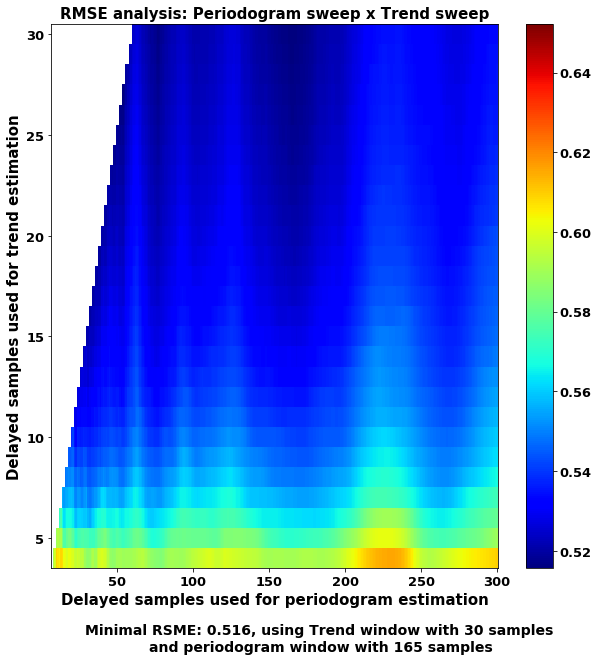

In [5]:
fig, ax = plt.subplots(figsize=(10,10))
cax = ax.imshow(RMSE[:,:], cmap="jet", aspect="auto")
plt.gca().invert_yaxis()
ax.set_title('RMSE analysis: Periodogram sweep x Trend sweep')
ax.set_ylim([windowMinSize + 0.5, windowMaxSize + 0.5])
ax.set_xlim([weightModelWindowMinSize + 0.5, weightModelWindowMaxSize + 0.5])
ax.set_xlabel('Delayed samples used for periodogram estimation')
ax.set_ylabel('Delayed samples used for trend estimation')
cbar = fig.colorbar(cax)
plt.figtext(0.5,  0.010, 'Minimal RSME: {:.3f}, using Trend window with {} samples \nand periodogram window with {} samples'.format(minimal, iMin, jMin), size = 14, horizontalalignment = 'center')

fig.savefig('{}/pdf/{}.{}'.format(saveFigDir, saveName, 'pdf'), bbox_inches='tight')
fig.savefig('{}/png/{}.{}'.format(saveFigDir, saveName, 'png'), bbox_inches='tight')

In [6]:
message  = 'Periodogram sweep deTrend analysis ({}, {}x{}) completed'.format(asset, windowMaxSize, weightModelWindowMaxSize)
imgPath  = '{}/png/{}.{}'.format(saveFigDir, saveName, 'png')
filePath = '{}/pdf/{}.{}'.format(saveFigDir, saveName, 'pdf')
bot.sendMessage(message, imgPath, filePath)